In [1]:
from pathlib import Path

import json

import pandas as pd
import numpy as np

In [2]:
from ppi_utils.reduce import dedup_pairs
from ppi_utils.pairs import estimate_bias, estimate_bias_per_species
from ppi_utils.api import uniprot_api_fetch
from ppi_utils.extract import ppis_to_hashes
from ppi_utils.general import get_seq_hash, get_ids

## Extract PPIs from the original hu.MAP 2.0

In [3]:
humap_dir = Path.cwd().parent / 'ppi_data/hu.MAP'
assert humap_dir.is_dir()
humap_dir

PosixPath('/home/quirin/PYTHON/ppi/ppi_data/hu.MAP')

There is a train-test-split already!?

In [4]:
humap = list()
for txt in sorted(humap_dir.glob('*.txt')):
    if 'complexes' in txt.stem:
        continue
    tx = pd.read_csv(txt, sep='\t', header=None, names=['ida', 'idb'])
    tx['label'] = 0 if 'neg' in txt.stem else 1
    tx['set_type'] = 'train' if 'train' in txt.stem else 'test'
    humap.append(tx)
humap = pd.concat(humap)

In [5]:
humap.head()

,ida,idb,label,set_type
0,Q99966,Q13393,0,test
1,P78352,Q15648,0,test
2,P42345,Q6WN34,0,test
3,P03891,Q9H0D2,0,test
4,Q9UJY1,Q9H0D2,0,test


In [6]:
h = dedup_pairs(humap.copy())
len(humap), len(humap) - len(h), 'That\'s huuuuuge!'

(3435064, 1417, "That's huuuuuge!")

In [7]:
humap = h
humap.head()

,ida,idb,label,set_type
0,Q13393,Q99966,0,test
1,P78352,Q15648,0,test
2,P42345,Q6WN34,0,test
3,P03891,Q9H0D2,0,test
4,Q9H0D2,Q9UJY1,0,test


In [8]:
humap.set_type.value_counts()
# train-test-split of roughly equal size?!

test     1798599
train    1635048
Name: set_type, dtype: int64

In [9]:
all_ids = dict()
for t in ['train', 'test']:
    h = humap.loc[humap.set_type == t]
    bias = estimate_bias(h)
    ids = set(h.ida) | set(h.idb)
    all_ids[t] = ids
    print(f'{t}:\tn_pairs = {len(h)}\tn_PPIs = {len(h.loc[h.label == 1])}\tbias = {bias[0]:.3f}\tn_uniprot_ids = {len(ids)}')
print(f'shared IDs: {len(all_ids["train"] & all_ids["test"])}')
'Mostly negatives - that\'s kind of good to see'

train:	n_pairs = 1635048	n_PPIs = 7172	bias = -0.228	n_uniprot_ids = 1937
test:	n_pairs = 1798599	n_PPIs = 8329	bias = -0.183	n_uniprot_ids = 2023
shared IDs: 968


"Mostly negatives - that's kind of good to see"

In [10]:
humap.loc[(humap.set_type == 'train')].label.value_counts()

0    1627876
1       7172
Name: label, dtype: int64

In [11]:
uniprot_ids = sorted(all_ids['train'] | all_ids['test'])
len(uniprot_ids), uniprot_ids[:7],

(2992, ['10207', '280964', '3507', '403846', '84311', 'A0AVF1', 'A0JLT2'])

In [12]:
uniprot_ids = [_id for _id in uniprot_ids if not _id.isnumeric()]
len(uniprot_ids), uniprot_ids[:4],

(2987, ['A0AVF1', 'A0JLT2', 'A1A4S6', 'A2A288'])

### Fetch UniProt sequences

In [ ]:
res = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/humap.fasta'))

In [ ]:
res

In [13]:
hash_humap = ppis_to_hashes(humap, Path('uniprot/humap.json'))
hash_humap.head()

,hash_A,hash_B,label,set_type
378407,CRC-000037AE195F7A9D,CRC-0008E21D66E8CFEC,0,test
74220,CRC-000037AE195F7A9D,CRC-000F380D23A9FE8F,0,train
610541,CRC-000037AE195F7A9D,CRC-0026F07D7AB33295,0,test
1084683,CRC-000037AE195F7A9D,CRC-003B3F654F0C60DF,0,test
1772333,CRC-000037AE195F7A9D,CRC-003FABF28F5405D0,0,test


In [14]:
hppis = hash_humap.loc[hash_humap.label == 1]
len(hppis)

15501

In [15]:
hppis.head()

,hash_A,hash_B,label,set_type
1378,CRC-000037AE195F7A9D,CRC-0249E6CA12F77934,1,test
7387,CRC-000037AE195F7A9D,CRC-0860CECC8BF674FE,1,test
1646,CRC-000037AE195F7A9D,CRC-1A73DD35A3501861,1,test
4761,CRC-000037AE195F7A9D,CRC-2023CA8590C7752C,1,train
3868,CRC-000037AE195F7A9D,CRC-26EC965C9239774E,1,test


In [16]:
len(hppis.loc[hppis.set_type == 'train'])

7172

In [17]:
len(hppis.loc[hppis.set_type == 'test'])

8329

In [18]:
ppis = humap.loc[humap.label == 1]
len(ppis)

15501

In [19]:
ppis.head()

,ida,idb,label,set_type
0,Q13616,Q9Y297,1,test
1,O15111,Q676U5,1,test
2,P06213,P35568,1,test
3,P11802,P24385,1,test
4,O00472,Q9HB65,1,test


In [20]:
len(ppis), len(hppis)

(15501, 15501)

### Don't need the hashing!

In [21]:
del hash_humap
del hppis

In [24]:
# look at an example
_id = 'P11802'
ppis.loc[(ppis.ida == _id) | (ppis.idb == _id)]

,ida,idb,label,set_type
3,P11802,P24385,1,test
537,P11802,P30279,1,test
3396,P11802,P38936,1,test
3908,P11802,P30281,1,test
4790,P11802,Q00534,1,test
1068,P11802,P12004,1,train


In [25]:
ppis.loc[ppis.ida == ppis.idb]
# There's a homodimer!

,ida,idb,label,set_type
3260,P0DMV9,P0DMV9,1,train


## Compare to the hu.MAP set as used by [Burke et al.](https://doi.org/10.1038/s41594-022-00910-8) on their [git](https://gitlab.com/ElofssonLab/huintaf2)

In [26]:
huintaf_dir = Path('/home/quirin/PYTHON/huintaf2')
huintaf = pd.read_csv(huintaf_dir / 'data/humap_pairs.txt', sep=' ', header=None, names=['ida', 'idb'])
len(huintaf)

57128

In [27]:
huintaf.head()

,ida,idb
0,A0A0B4J2A2,A0A075B759
1,A6NI28,A1A4S6
2,A6NJ78,A6NFY7
3,A8MZ97,A6NKD9
4,C9J7I0,A5D8V6


In [28]:
# also no duplicates there
assert len(dedup_pairs(huintaf)) == len(huintaf)

In [29]:
huintaf.loc[(huintaf.ida == _id) | (huintaf.idb == _id)]
# are these predictions? Cause it's sure as heck not the same stuff ...

,ida,idb
4641,P42772,P11802
4643,P42773,P11802
6591,P55273,P11802
10272,Q00534,P11802
16377,Q5TC84,P11802
22713,Q8N726,P11802


## Re-try from OG hu.MAP
Burke et al say they selected the hu.MAP PPIs with a score `> .5`

In [30]:
wumap = pd.read_csv(humap_dir / 'humap2_ppis_ACC_20200821.pairsWprob',
                    sep='\t', header=None, names=['ida', 'idb', 'prob'])
len(wumap)

17526311

In [31]:
wumap.head()

,ida,idb,prob
0,P46926,Q8TDQ7,1.0
1,P43631,Q14954,1.0
2,P43631,Q14953,1.0
3,P43631,P43629,1.0
4,100287045,Q86YD7,1.0


In [32]:
wumap = wumap.loc[wumap.prob >= .5]
len(wumap)
# now that's a relief!

11043

In [33]:
# also drop weird numeric IDs
wumap= wumap.loc[(~wumap.ida.str.isnumeric())
                 & (~wumap.idb.str.isnumeric())]
len(wumap)

10868

In [34]:
len(wumap)

10868

In [35]:
wumap.loc[(wumap.ida == _id) | (wumap.idb == _id)]

,ida,idb,prob
3387,P11802,P42772,0.999704
6202,P11802,Q8N726,0.974196
9725,P11802,P42773,0.654257
9768,P11802,Q5TC84,0.649962


In [36]:
# Again - not the same as extracted from the test split!
ppis.loc[(ppis.ida == _id) | (ppis.idb == _id)]

,ida,idb,label,set_type
3,P11802,P24385,1,test
537,P11802,P30279,1,test
3396,P11802,P38936,1,test
3908,P11802,P30281,1,test
4790,P11802,Q00534,1,test
1068,P11802,P12004,1,train


In [37]:
# verify this is not my mistake some more
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt

P11802	P24385
P11802	P30279
P11802	P38936
P11802	P30281
P11802	Q00534


In [38]:
# a partner with a high annotated interaction p
!grep "P11802" $humap_dir/humap2_ppis_ACC_20200821.pairsWprob | grep "P42772"

P11802	P42772	0.999704


In [39]:
# a second partner from the test set
!grep "P11802" $humap_dir/humap2_ppis_ACC_20200821.pairsWprob | grep "P30279"

P11802	P30279	3.04045e-07


In [40]:
# search first one in the positives
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt | grep "P42772"

In [41]:
# in the negatives
!grep "P11802" $humap_dir/humap2_neg_test_ppis_ACC_20200818.txt | grep "P42772"

In [42]:
# search second in the positives
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt | grep "P30279"

P11802	P30279


In [43]:
# second in the negatives
!grep "P11802" $humap_dir/humap2_neg_test_ppis_ACC_20200818.txt | grep "P30279"

# WTF hu.MAP?

ok - still find a match in huintaf!

## start from the end

In [44]:
hua = pd.read_csv(huintaf_dir / 'leo/table_AF2_HURI_HuMap_UNIQUE.csv', sep=',')
len(hua)

65484

In [45]:
hua.head()

,unique_ID,duplicates,id1,id2,NumRes,IF_plDDT,plDDT,pDockQ,DockQall,PDB,...,structure_file,NumDiso1.90,NumDiso1.70.90,NumDiso1.50.70,NumDiso1.50,NumDiso2.90,NumDiso2.70.90,NumDiso2.50.70,NumDiso2.50,NumOverlap
0,A0A024R0Y4_O14964,1,O14964,A0A024R0Y4,92,67.09186,67.37455,0.077304,NaN,NaN,...,ENSG00000185359-ENSG00000276234.pdb,114.0,253.0,60.0,350.0,72.0,286.0,42.0,43.0,2.0
1,A0A024R0Y4_O15287,1,O15287,A0A024R0Y4,35,68.53878,77.09663,0.038752,NaN,NaN,...,ENSG00000221829-ENSG00000276234.pdb,130.0,339.0,74.0,79.0,41.0,308.0,66.0,28.0,0.0
2,A0A024R0Y4_O60573,1,O60573,A0A024R0Y4,40,59.69327,78.52047,0.034888,NaN,NaN,...,ENSG00000135930-ENSG00000276234.pdb,105.0,58.0,15.0,67.0,118.0,263.0,28.0,34.0,0.0
3,A0A024R0Y4_O75431,1,O75431,A0A024R0Y4,51,76.82288,81.05951,0.075548,NaN,NaN,...,ENSG00000128654-ENSG00000276234.pdb,183.0,56.0,5.0,19.0,42.0,294.0,70.0,37.0,0.0
4,A0A024R0Y4_O75528,1,O75528,A0A024R0Y4,362,90.26991,76.77518,0.730883,NaN,NaN,...,ENSG00000171148-ENSG00000276234.pdb,134.0,119.0,52.0,127.0,180.0,210.0,22.0,31.0,0.0


In [46]:
hua.Dataset.value_counts()

HURI          55277
HuMap          9898
HuMap;HURI      309
Name: Dataset, dtype: int64

In [105]:
hua.Dataset_max.value_counts()

HURI     55439
HuMap    10045
Name: Dataset_max, dtype: int64

In [352]:
r2k = pd.read_csv(huintaf_dir / 'data/random.csv', sep=',')
r2k.head()

,Name,pDockQ,NumRes,IF_plDDT,plDDT1,plDDT2,NumDiso1+90,NumDiso1-70-90,NumDiso1-50-70,NumDiso1-50,NumDiso2+90,NumDiso2-70-90,NumDiso2-50-70,NumDiso2-50,NumOverlap,len1,len2
0,O00139-P40429,0.041981,49,65.595918,75.346912,87.722660,232,262,83,129,128,56,15,4,0,706,203
1,O00231-P31946,0.034794,34,62.204118,75.470284,84.597642,7,289,124,2,88,140,6,12,0,422,246
2,O00231-Q06330,0.061639,31,84.275161,84.527464,79.542340,84,318,20,0,221,170,33,76,0,422,500
3,O00231-Q8N488,0.060234,55,71.824909,81.943341,50.807281,59,323,40,0,0,50,29,149,0,422,228
4,O00231-Q9NWR8,0.031359,3,70.566667,83.936303,71.687143,108,290,23,1,48,178,39,71,0,422,336


In [353]:
r2k[['ida', 'idb']] = r2k.Name.str.split('-', expand=True)
r2k = r2k[['ida', 'idb'] + [c for c in r2k.columns if c not in ['ida', 'idb']]].rename(columns=dict(pDockQ='pdockq'))
r2k.head()

,ida,idb,Name,pdockq,NumRes,IF_plDDT,plDDT1,plDDT2,NumDiso1+90,NumDiso1-70-90,NumDiso1-50-70,NumDiso1-50,NumDiso2+90,NumDiso2-70-90,NumDiso2-50-70,NumDiso2-50,NumOverlap,len1,len2
0,O00139,P40429,O00139-P40429,0.041981,49,65.595918,75.346912,87.722660,232,262,83,129,128,56,15,4,0,706,203
1,O00231,P31946,O00231-P31946,0.034794,34,62.204118,75.470284,84.597642,7,289,124,2,88,140,6,12,0,422,246
2,O00231,Q06330,O00231-Q06330,0.061639,31,84.275161,84.527464,79.542340,84,318,20,0,221,170,33,76,0,422,500
3,O00231,Q8N488,O00231-Q8N488,0.060234,55,71.824909,81.943341,50.807281,59,323,40,0,0,50,29,149,0,422,228
4,O00231,Q9NWR8,O00231-Q9NWR8,0.031359,3,70.566667,83.936303,71.687143,108,290,23,1,48,178,39,71,0,422,336


In [354]:
uniprot_ids = get_ids(hua)
len(uniprot_ids)

9932

In [355]:
r2k_ids = get_ids(r2k)
new_r2k_ids = r2k_ids - uniprot_ids
len(new_r2k_ids), sorted(new_r2k_ids)[:6]

(19, ['O00443', 'P02462', 'P02774', 'P12882', 'P13535', 'P23416'])

In [356]:
uniprot_ids |= new_r2k_ids
len(uniprot_ids)

9951

In [ ]:
_ = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/huintaf.fasta'))

In [123]:
res = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/huintaf.fasta'))

jobId: 9e89f91d0c8bcb23b1342861bf8b15203a6ec807
huintaf: query + tab ... 9953:0
huintaf: fasta ...API FASTA: 19c62e0601d5cbcb12b1f9ba7983e7fc464ad2c018a48d67f6b2deeb9be4b00d


hash FASTA: 9949it [00:01, 6412.60it/s]
fetch isoforms/archive: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


In [124]:
# don't need to call the API again!
with open(Path('uniprot/huintaf.json'), 'r') as json_file:
    res = json.load(json_file)

In [125]:
len(set(res)), len(set(res.values()))

(9951, 9934)

In [126]:
hua.head()

,unique_ID,duplicates,id1,id2,NumRes,IF_plDDT,plDDT,pDockQ,DockQall,PDB,...,structure_file,NumDiso1.90,NumDiso1.70.90,NumDiso1.50.70,NumDiso1.50,NumDiso2.90,NumDiso2.70.90,NumDiso2.50.70,NumDiso2.50,NumOverlap
0,A0A024R0Y4_O14964,1,O14964,A0A024R0Y4,92,67.09186,67.37455,0.077304,NaN,NaN,...,ENSG00000185359-ENSG00000276234.pdb,114.0,253.0,60.0,350.0,72.0,286.0,42.0,43.0,2.0
1,A0A024R0Y4_O15287,1,O15287,A0A024R0Y4,35,68.53878,77.09663,0.038752,NaN,NaN,...,ENSG00000221829-ENSG00000276234.pdb,130.0,339.0,74.0,79.0,41.0,308.0,66.0,28.0,0.0
2,A0A024R0Y4_O60573,1,O60573,A0A024R0Y4,40,59.69327,78.52047,0.034888,NaN,NaN,...,ENSG00000135930-ENSG00000276234.pdb,105.0,58.0,15.0,67.0,118.0,263.0,28.0,34.0,0.0
3,A0A024R0Y4_O75431,1,O75431,A0A024R0Y4,51,76.82288,81.05951,0.075548,NaN,NaN,...,ENSG00000128654-ENSG00000276234.pdb,183.0,56.0,5.0,19.0,42.0,294.0,70.0,37.0,0.0
4,A0A024R0Y4_O75528,1,O75528,A0A024R0Y4,362,90.26991,76.77518,0.730883,NaN,NaN,...,ENSG00000171148-ENSG00000276234.pdb,134.0,119.0,52.0,127.0,180.0,210.0,22.0,31.0,0.0


## run SETH

In [ ]:
#%env HOME=/mnt/project/kaindl
!bash "huintaf_seth.sh"

In [136]:
with Path('uniprot/huintaf_seth_scores.json').open('r') as json_file:
    seth_scores = json.load(json_file)
_id = next(iter(seth_scores.keys()))
_id, len(seth_scores)

('CRC-148327B7C5E264EF', 9935)

In [137]:
seth_scores[_id].keys()

dict_keys(['seq', 'diso_pred', 'confidence', 'zscores'])

In [138]:
mp = hua[['id1', 'id2', 'pDockQ', 'Dataset_max', ]].copy()
mp.columns = ['ida', 'idb', 'pdockq', 'dataset']
len(mp), len(wumap)

(65484, 10868)

In [139]:
mp.head()

,ida,idb,pdockq,dataset
0,O14964,A0A024R0Y4,0.077304,HURI
1,O15287,A0A024R0Y4,0.038752,HURI
2,O60573,A0A024R0Y4,0.034888,HURI
3,O75431,A0A024R0Y4,0.075548,HURI
4,O75528,A0A024R0Y4,0.730883,HURI


In [140]:
wumap.head()

,ida,idb,prob
0,P46926,Q8TDQ7,1.0
1,P43631,Q14954,1.0
2,P43631,Q14953,1.0
3,P43631,P43629,1.0
10,Q96S59,Q9NWU2,1.0


In [141]:
mp = pd.merge(mp, wumap, on=['ida', 'idb'], how='left')
mp.prob = mp.prob.fillna(1)
len(mp)

65484

In [142]:
mp.head()

,ida,idb,pdockq,dataset,prob
0,O14964,A0A024R0Y4,0.077304,HURI,1.0
1,O15287,A0A024R0Y4,0.038752,HURI,1.0
2,O60573,A0A024R0Y4,0.034888,HURI,1.0
3,O75431,A0A024R0Y4,0.075548,HURI,1.0
4,O75528,A0A024R0Y4,0.730883,HURI,1.0


In [143]:
# don't need to call the API again!
with open(Path('uniprot/huintaf.json'), 'r') as json_file:
    res = json.load(json_file)

In [144]:
mp['hash_A'] = mp.ida.apply(res.get)
mp['hash_B'] = mp.idb.apply(res.get)

In [145]:
# calculate the average per-protein ChiZod-score
for _char in 'ab':
    mp[f'z{_char.lower()}'] = mp[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['zscores']).mean())
# and the average binary "residue-is-disordered" label
for _char in 'ab':
    mp[f'd{_char.lower()}'] = mp[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['diso_pred']).mean())

mp['zc'] = mp[['za', 'zb']].min(axis=1)
mp['dc'] = mp[['da', 'db']].max(axis=1)

In [146]:
# save
capris = ['incorrect', 'acceptable', 'medium', 'high']
mp['capri'] = mp.pdockq.apply(lambda pq: 'incorrect' if pq < .23 else 'acceptable' if pq < .5 else 'medium' if pq < .8 else 'high')
mp.loc[mp.dataset == 'HURI', 'dataset'] = 'HuRI'
mp.loc[mp.dataset != 'HuRI', 'dataset'] = 'hu.MAP'
mp.to_csv('huintaf_scores.tsv', sep='\t', header=True, index=False)
mp.head()

,ida,idb,pdockq,dataset,prob,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,O14964,A0A024R0Y4,0.077304,HuRI,1.0,CRC-DD64167A19DCF030,CRC-27D3F4F4D5EFF3C8,6.937132,11.84117,0.516088,0.158014,6.937132,0.516088,incorrect
1,O15287,A0A024R0Y4,0.038752,HuRI,1.0,CRC-4BC7475472AC3C84,CRC-27D3F4F4D5EFF3C8,11.711823,11.84117,0.127010,0.158014,11.711823,0.158014,incorrect
2,O60573,A0A024R0Y4,0.034888,HuRI,1.0,CRC-3D3075BFA48B3C12,CRC-27D3F4F4D5EFF3C8,9.707791,11.84117,0.334694,0.158014,9.707791,0.334694,incorrect
3,O75431,A0A024R0Y4,0.075548,HuRI,1.0,CRC-3A2EF476F1C78465,CRC-27D3F4F4D5EFF3C8,12.701179,11.84117,0.087452,0.158014,11.841170,0.158014,incorrect
4,O75528,A0A024R0Y4,0.730883,HuRI,1.0,CRC-C86153CFA83F9226,CRC-27D3F4F4D5EFF3C8,8.649690,11.84117,0.388889,0.158014,8.649690,0.388889,medium


In [6]:
mp = pd.read_csv('huintaf_scores.tsv', sep='\t', header=0)
mp.head()

,ida,idb,pdockq,dataset,prob,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,O14964,A0A024R0Y4,0.077304,HuRI,1.0,CRC-DD64167A19DCF030,CRC-27D3F4F4D5EFF3C8,6.937132,11.84117,0.516088,0.158014,6.937132,0.516088,incorrect
1,O15287,A0A024R0Y4,0.038752,HuRI,1.0,CRC-4BC7475472AC3C84,CRC-27D3F4F4D5EFF3C8,11.711823,11.84117,0.127010,0.158014,11.711823,0.158014,incorrect
2,O60573,A0A024R0Y4,0.034888,HuRI,1.0,CRC-3D3075BFA48B3C12,CRC-27D3F4F4D5EFF3C8,9.707791,11.84117,0.334694,0.158014,9.707791,0.334694,incorrect
3,O75431,A0A024R0Y4,0.075548,HuRI,1.0,CRC-3A2EF476F1C78465,CRC-27D3F4F4D5EFF3C8,12.701179,11.84117,0.087452,0.158014,11.841170,0.158014,incorrect
4,O75528,A0A024R0Y4,0.730883,HuRI,1.0,CRC-C86153CFA83F9226,CRC-27D3F4F4D5EFF3C8,8.649690,11.84117,0.388889,0.158014,8.649690,0.388889,medium


In [7]:
len(mp)

65484

In [162]:
r2k[['ida', 'idb', 'pDockQ']]

,ida,idb,Name,pDockQ,NumRes,IF_plDDT,plDDT1,plDDT2,NumDiso1+90,NumDiso1-70-90,...,len1,len2,hash_A,hash_B,za,zb,da,db,zc,dc
0,O00139,P40429,O00139-P40429,0.041981,49,65.595918,75.346912,87.722660,232,262,...,706,203,CRC-A407D84B6BD04ACF,CRC-3E80D0AB77A0D406,9.698229,10.831108,0.264873,0.187192,9.698229,0.264873
1,O00231,P31946,O00231-P31946,0.034794,34,62.204118,75.470284,84.597642,7,289,...,422,246,CRC-CE113054CBEBDB05,CRC-6BE1A9BF97468017,12.711342,12.238672,0.030806,0.069106,12.238672,0.069106
2,O00231,Q06330,O00231-Q06330,0.061639,31,84.275161,84.527464,79.542340,84,318,...,422,500,CRC-CE113054CBEBDB05,CRC-91E50D2DE9087EDA,12.711342,10.337528,0.030806,0.178000,10.337528,0.178000
3,O00231,Q8N488,O00231-Q8N488,0.060234,55,71.824909,81.943341,50.807281,59,323,...,422,228,CRC-CE113054CBEBDB05,CRC-EB9593460A3F0F4C,12.711342,3.565209,0.030806,0.815789,3.565209,0.815789
4,O00231,Q9NWR8,O00231-Q9NWR8,0.031359,3,70.566667,83.936303,71.687143,108,290,...,422,336,CRC-CE113054CBEBDB05,CRC-90C4BEBD5B1EFFD9,12.711342,10.542253,0.030806,0.202381,10.542253,0.202381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,Q9Y676,P52799,Q9Y676-P52799,0.037346,37,65.622973,72.353450,65.704264,89,72,...,258,333,CRC-B4C83E5593796C5D,CRC-6D9932A632626AEA,7.786106,8.731240,0.445736,0.414414,7.786106,0.445736
1845,Q9Y676,Q3B726,Q9Y676-Q3B726,0.033830,32,60.299063,71.578450,62.102396,84,74,...,258,338,CRC-B4C83E5593796C5D,CRC-6DA3829E74E5D25C,7.786106,7.728526,0.445736,0.446746,7.728526,0.446746
1846,Q9Y676,Q96KS0,Q9Y676-Q96KS0,0.075245,54,75.663704,69.166899,63.949951,75,62,...,258,407,CRC-B4C83E5593796C5D,CRC-F172E9B0482C9CF3,7.786106,6.678558,0.445736,0.533170,6.678558,0.533170
1847,Q9Y676,Q9UBK7,Q9Y676-Q9UBK7,0.031332,2,63.975000,68.385310,76.864825,71,63,...,258,228,CRC-B4C83E5593796C5D,CRC-96947DD254886B3C,7.786106,10.459220,0.445736,0.228070,7.786106,0.445736


In [357]:
r2k['hash_A'] = r2k.ida.apply(res.get)
r2k['hash_B'] = r2k.idb.apply(res.get)
# calculate the average per-protein ChiZod-score
for _char in 'ab':
    r2k[f'z{_char.lower()}'] = r2k[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['zscores']).mean())
# and the average binary "residue-is-disordered" label
for _char in 'ab':
    r2k[f'd{_char.lower()}'] = r2k[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['diso_pred']).mean())

r2k['zc'] = r2k[['za', 'zb']].min(axis=1)
r2k['dc'] = r2k[['da', 'db']].max(axis=1)
r2k['capri'] = r2k.pdockq.apply(
    lambda pq: 'incorrect' if pq < .23 else 'acceptable' if pq < .5 else 'medium' if pq < .8 else 'high')
r2k['dataset'] = '1849 random'
r2k['prob'] = 0
r2k = r2k[mp.columns]
len(r2k)

1849

In [358]:
r2k.to_csv('huintaf_r2k_scores.tsv', sep='\t', header=True, index=False)

In [4]:
r2k = pd.read_csv('huintaf_r2k_scores.tsv', sep='\t', header=0)
r2k.head()

,ida,idb,pdockq,dataset,prob,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,O00139,P40429,0.041981,1849 random,0,CRC-A407D84B6BD04ACF,CRC-3E80D0AB77A0D406,9.698229,10.831108,0.264873,0.187192,9.698229,0.264873,incorrect
1,O00231,P31946,0.034794,1849 random,0,CRC-CE113054CBEBDB05,CRC-6BE1A9BF97468017,12.711342,12.238672,0.030806,0.069106,12.238672,0.069106,incorrect
2,O00231,Q06330,0.061639,1849 random,0,CRC-CE113054CBEBDB05,CRC-91E50D2DE9087EDA,12.711342,10.337528,0.030806,0.178000,10.337528,0.178000,incorrect
3,O00231,Q8N488,0.060234,1849 random,0,CRC-CE113054CBEBDB05,CRC-EB9593460A3F0F4C,12.711342,3.565209,0.030806,0.815789,3.565209,0.815789,incorrect
4,O00231,Q9NWR8,0.031359,1849 random,0,CRC-CE113054CBEBDB05,CRC-90C4BEBD5B1EFFD9,12.711342,10.542253,0.030806,0.202381,10.542253,0.202381,incorrect


## plot!

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib as mpl
from ppi_utils.general import to_lines
%matplotlib inline

In [14]:
# !mkdir -p plots

In [18]:
sns.set_theme(style='ticks')
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['legend.frameon'] = False
h = 3  # plot height
capris = ['incorrect', 'acceptable', 'medium', 'high']

In [10]:
ours = pd.read_csv('scores.tsv', sep='\t', header=0)
ours['zc'] = ours[['za', 'zb']].min(axis=1)
ours['dc'] = ours[['da', 'db']].max(axis=1)
ours['dataset'] = 'HuRI 1030'
ours['prob'] = ours.label
ours[['hash_A', 'hash_B']] = ours[['ida', 'idb']]
ours = ours[mp.columns]
ours.head()

,ida,idb,pdockq,dataset,prob,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,0.338790,HuRI 1030,1,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,6.533676,10.537396,0.591304,0.182609,6.533676,0.591304,acceptable
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,0.044733,HuRI 1030,1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,6.533676,8.990527,0.591304,0.307692,6.533676,0.591304,incorrect
2,CRC-001576EA78C61C85,CRC-2743716544288776,0.051711,HuRI 1030,1,CRC-001576EA78C61C85,CRC-2743716544288776,6.533676,10.560456,0.591304,0.357664,6.533676,0.591304,incorrect
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,0.000000,HuRI 1030,1,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,6.533676,11.606744,0.591304,0.094142,6.533676,0.591304,incorrect
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,0.000000,HuRI 1030,1,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,6.533676,9.997539,0.591304,0.304288,6.533676,0.591304,incorrect


## histograms of pDockQ

In [11]:
murks = pd.concat((mp, r2k, ours))
murks.prob = murks.prob > 0
murks.head()

,ida,idb,pdockq,dataset,prob,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,O14964,A0A024R0Y4,0.077304,HuRI,True,CRC-DD64167A19DCF030,CRC-27D3F4F4D5EFF3C8,6.937132,11.84117,0.516088,0.158014,6.937132,0.516088,incorrect
1,O15287,A0A024R0Y4,0.038752,HuRI,True,CRC-4BC7475472AC3C84,CRC-27D3F4F4D5EFF3C8,11.711823,11.84117,0.127010,0.158014,11.711823,0.158014,incorrect
2,O60573,A0A024R0Y4,0.034888,HuRI,True,CRC-3D3075BFA48B3C12,CRC-27D3F4F4D5EFF3C8,9.707791,11.84117,0.334694,0.158014,9.707791,0.334694,incorrect
3,O75431,A0A024R0Y4,0.075548,HuRI,True,CRC-3A2EF476F1C78465,CRC-27D3F4F4D5EFF3C8,12.701179,11.84117,0.087452,0.158014,11.841170,0.158014,incorrect
4,O75528,A0A024R0Y4,0.730883,HuRI,True,CRC-C86153CFA83F9226,CRC-27D3F4F4D5EFF3C8,8.649690,11.84117,0.388889,0.158014,8.649690,0.388889,medium


/home/quirin/mambaforge/envs/ppi/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


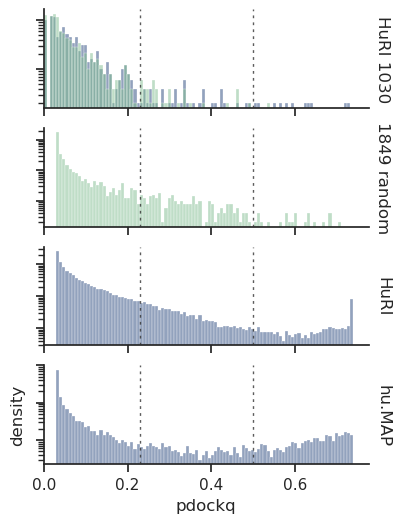

In [16]:
l, m, r = sns.color_palette('crest', 7)[0::3]
pal = [l, r]


sn = sns.displot(
    data=murks,
    x='pdockq',
    row='dataset', row_order=['HuRI 1030', '1849 random', 'HuRI', 'hu.MAP'],
    hue='prob', palette=pal,
    legend=False,
    bins=100,
    stat='density', common_norm=True,
    height=1.4, aspect=3,
    facet_kws=dict(margin_titles=True, sharey=False),
)

sn.set(yscale='log', ylabel=None, yticklabels=[], xlim=(0, None))
sn.axes.flatten()[-1].set(ylabel='density')
for ax in sn.axes.flatten():
    for l in [.23, .5, .8]:
        ax.axvline(x=l, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
sn.set_titles(row_template='{row_name}')
plt.subplots_adjust(hspace=.2)
sn.savefig('plots/pdock_hists.pdf')
# this one is a bit useless - look at the margin plots of the final one!

In [224]:
mp.head()

,ida,idb,pdockq,dataset,prob,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,O14964,A0A024R0Y4,0.077304,HuRI,1.0,CRC-DD64167A19DCF030,CRC-27D3F4F4D5EFF3C8,6.937132,11.84117,0.516088,0.158014,6.937132,0.516088,incorrect
1,O15287,A0A024R0Y4,0.038752,HuRI,1.0,CRC-4BC7475472AC3C84,CRC-27D3F4F4D5EFF3C8,11.711823,11.84117,0.127010,0.158014,11.711823,0.158014,incorrect
2,O60573,A0A024R0Y4,0.034888,HuRI,1.0,CRC-3D3075BFA48B3C12,CRC-27D3F4F4D5EFF3C8,9.707791,11.84117,0.334694,0.158014,9.707791,0.334694,incorrect
3,O75431,A0A024R0Y4,0.075548,HuRI,1.0,CRC-3A2EF476F1C78465,CRC-27D3F4F4D5EFF3C8,12.701179,11.84117,0.087452,0.158014,11.841170,0.158014,incorrect
4,O75528,A0A024R0Y4,0.730883,HuRI,1.0,CRC-C86153CFA83F9226,CRC-27D3F4F4D5EFF3C8,8.649690,11.84117,0.388889,0.158014,8.649690,0.388889,medium


## HuRI / hu.MAP: histogram of disorder by CAPRI

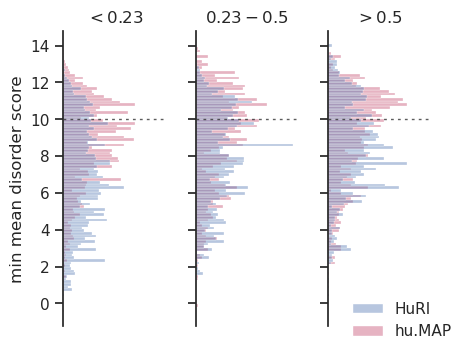

In [225]:
sn = sns.displot(
    data=mp,
    y='zc',
    hue='dataset',
    col='capri', col_order=capris[:-1],
    palette={'HuRI': '#4c72b0', 'hu.MAP': '#c14168'},
    bins=100,
    alpha=.4,
    stat='density', common_norm=False,
    height=4, aspect=.4,
    facet_kws=dict(margin_titles=True),
)

sn.set(yscale='linear', xlabel=None, xticks=[])
sn.despine(bottom=True)
sn.axes.flatten()[0].set(xlabel=None, ylabel='min mean disorder score')
sn.set_titles(col_template='{col_name}')
for ax, q in zip(sn.axes.flatten(), ['$< 0.23$', '$0.23 - 0.5$', '$> 0.5$']):
    ax.axhline(y=10, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
    # ax.text(0, 1, q, ha='center', va='bottom', transform=ax.transAxes)
    ax.set_title(q)
sns.move_legend(sn, loc='lower right', frameon=False,
                bbox_to_anchor=(.8, .1),
                title=None, ncol=1)
sn.savefig('plots/chezods_by_capri_and_dataset.pdf')
# this complements the final one well

## our data: histogram of disorder by CAPRI

In [21]:
ours.head()

,ida,idb,pdockq,dataset,prob,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,0.338790,HuRI 1030,1,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,6.533676,10.537396,0.591304,0.182609,6.533676,0.591304,acceptable
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,0.044733,HuRI 1030,1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,6.533676,8.990527,0.591304,0.307692,6.533676,0.591304,incorrect
2,CRC-001576EA78C61C85,CRC-2743716544288776,0.051711,HuRI 1030,1,CRC-001576EA78C61C85,CRC-2743716544288776,6.533676,10.560456,0.591304,0.357664,6.533676,0.591304,incorrect
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,0.000000,HuRI 1030,1,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,6.533676,11.606744,0.591304,0.094142,6.533676,0.591304,incorrect
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,0.000000,HuRI 1030,1,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,6.533676,9.997539,0.591304,0.304288,6.533676,0.591304,incorrect


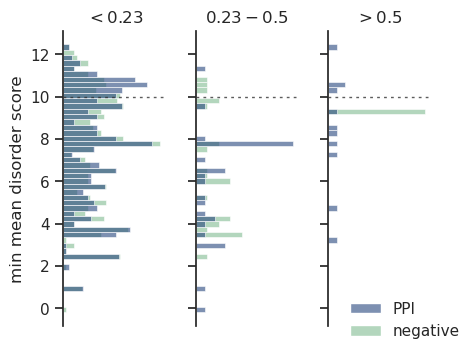

In [97]:
l, m, r = sns.color_palette('crest', 7)[0::3]
pal = [l, r]

ou = ours.copy()
ou['label'] = ou.prob.apply(lambda p: 'PPI' if p else 'negative')

sn = sns.displot(
    data=ou,
    y='zc',
    hue='label',
    col='capri', col_order=capris[:-1],
    palette=pal[::-1],
    # palette={'HuRI': '#4c72b0', 'hu.MAP': '#c14168'},
    bins=50,
    alpha=.6,
    stat='density', common_norm=False,
    height=4, aspect=.4,
    facet_kws=dict(margin_titles=True, sharex=False),
)
axes = sn.axes.flatten()

sn.set(yscale='linear', xlabel=None, xticks=[])
sn.despine(bottom=True)
axes[0].set(xlabel=None, ylabel='min mean disorder score')
sn.set_titles(col_template='{col_name}')
for ax, q in zip(sn.axes.flatten(), ['$< 0.23$', '$0.23 - 0.5$', '$> 0.5$']):
    ax.axhline(y=10, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
    # ax.text(0, 1, q, ha='center', va='bottom', transform=ax.transAxes)
    ax.set_title(q)
sns.move_legend(sn, loc='lower right', frameon=False,
                bbox_to_anchor=(.8, .1),
                title=None, ncol=1)

sn.savefig('plots/chezods_by_capri_ours.pdf')
# this complements the final one well

In [90]:
pd.concat((ours, mp, r2k)).dataset.unique()

array(['HuRI 1030', 'HuRI', 'hu.MAP', '1849 random'], dtype=object)

/home/quirin/mambaforge/envs/ppi/lib/python3.10/site-packages/seaborn/axisgrid.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


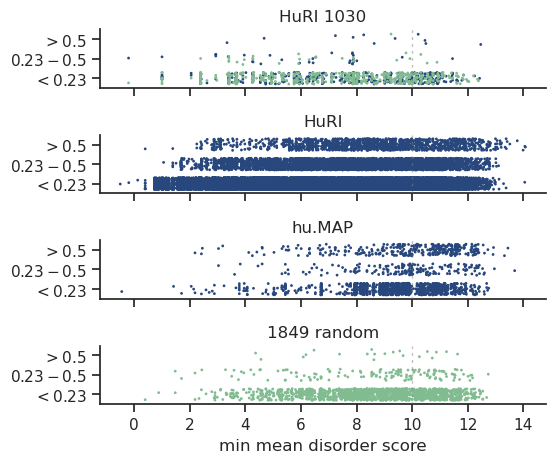

In [193]:
st = sns.catplot(
    data=pd.concat((ours, mp, r2k)),
    row='dataset', row_order=['HuRI 1030', 'HuRI', 'hu.MAP', '1849 random'],
    y='capri', order=capris[::-1][1:],
    x='zc',
    dodge=False,
    orient='h',
    size=2,
    jitter=.3,
    hue='prob', hue_order=[0, 1], palette=pal,
    legend=False,
    height=1.2, aspect=5,
)
# st.legend.set_title(None)
st.set(ylabel=None, xlabel='min mean disorder score')
st.set(yticklabels=['$< 0.23$', '$0.23 - 0.5$', '$> 0.5$'][::-1])
# plt.subplots_adjust(hspace=.4)
st.set_titles(row_template='{row_name}')
for ax in st.axes.flatten():
    ax.axvline(x=10, dashes=(2, 3), c='.5', lw=1, alpha=.5, zorder=99)
sns.despine()
st.savefig('plots/chezods_strip.pdf')

- `pdockq` hardly correlates with our binary labels, nor with hu.MAP values
 - in particular in our set: confident predictions are usually PPIs
- `pdockq`: us *vs* them
- confident predictions are more frequent for ordered pairs
- both are more frequent in hu.MAP than in HuRI


## make a pile

In [318]:
aff = pd.concat((ours, mp, r2k))
aff.loc[(aff.dataset == 'HuRI 1030') & (aff.prob == 0), ['dataset', 'prob']] = '514 HuRI $-$', 0
aff.loc[(aff.dataset == 'HuRI 1030') & (aff.prob == 1), ['dataset', 'prob']] = '516 HuRI $+$', 1
aff.capri = pd.Categorical(aff.capri, capris[::-1][1:])
sets = ['516 HuRI $+$', '514 HuRI $-$', 'HuRI', 'hu.MAP', '1849 random']
aff.head()

,ida,idb,pdockq,dataset,prob,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,0.338790,516 HuRI $+$,1.0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,6.533676,10.537396,0.591304,0.182609,6.533676,0.591304,acceptable
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,0.044733,516 HuRI $+$,1.0,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,6.533676,8.990527,0.591304,0.307692,6.533676,0.591304,incorrect
2,CRC-001576EA78C61C85,CRC-2743716544288776,0.051711,516 HuRI $+$,1.0,CRC-001576EA78C61C85,CRC-2743716544288776,6.533676,10.560456,0.591304,0.357664,6.533676,0.591304,incorrect
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,0.000000,516 HuRI $+$,1.0,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,6.533676,11.606744,0.591304,0.094142,6.533676,0.591304,incorrect
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,0.000000,516 HuRI $+$,1.0,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,6.533676,9.997539,0.591304,0.304288,6.533676,0.591304,incorrect


## two good ecdf plots

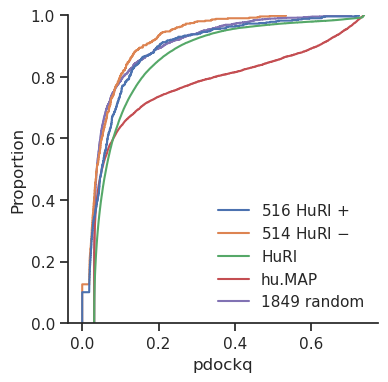

In [386]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.ecdfplot(data=aff,
             x='pdockq',
             hue='dataset',
             ax=ax,
             )
sns.despine()
ax.get_legend().set_title(None)
fig.savefig('plots/ecdf_pdockq.pdf')
# hu.MAP gives the highest pDockQs

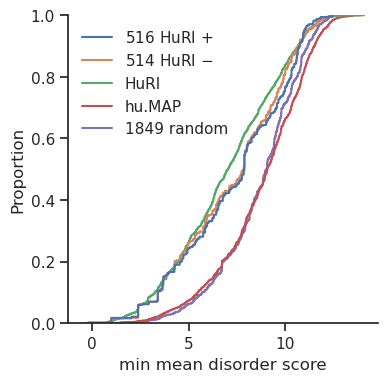

In [390]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.ecdfplot(data=aff,
             x='zc',
             hue='dataset',
             ax=ax,
             )
ax.set(xlabel='min mean disorder score')
ax.get_legend().set_title(None)
sns.despine()
fig.savefig('plots/ecdf_chezod.pdf')
# hu.MAP and the set of random pairs are most ordered, HuRI is most disordered

## ok-ish bivariate hist

## meh-ish violin plot

In [325]:
spearmanr(mp.pdockq, mp.zc)

SignificanceResult(statistic=0.17084987593941106, pvalue=0.0)

In [326]:
len(mp)

65484

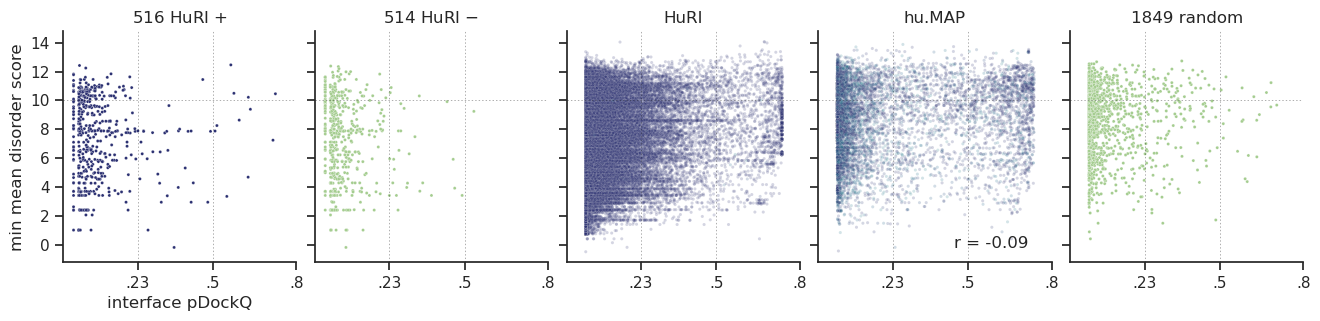

In [378]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(nrows=1, ncols=len(sets),
                         figsize=(3.2 * len(sets), 3),
                         sharex=True, sharey=True)
shrink = ['HuRI', 'hu.MAP']
for j, (_set, ax) in enumerate(zip(sets, axes)):
    df = aff.loc[aff.dataset == _set]
    sn = sns.scatterplot(
        data=df,
        x='pdockq',
        y='zc',
        hue='prob', palette='crest', hue_norm=(0, 1),
        s=5,
        alpha=1 if _set not in shrink else .2,
        ax=ax,
        legend=False,
    )
    ax.set(title=_set, xticks=[.23, .5, .8], xticklabels=['.23', '.5', '.8'], ylabel=None, xlabel=None)
    for l in [.23, .5]:
        kw = dict(dashes=(2, 3), c='.1', lw=.5, alpha=.5, zorder=99)
        ax.axvline(x=l, **kw)
    ax.axhline(y=10, **kw)
    if not j:
        ax.set(ylabel='min mean disorder score', xlabel='interface pDockQ')
    if _set == 'hu.MAP':
        rho = spearmanr(df.pdockq, df.prob)[0]
        ax.text(.9, .05, f'r = {rho:.2f}', ha='right', va='bottom', transform=ax.transAxes)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplots_adjust(wspace=.08)
sns.despine()
fig.savefig('plots/chezod_simpler.pdf')
# the most confident predictions are positives!

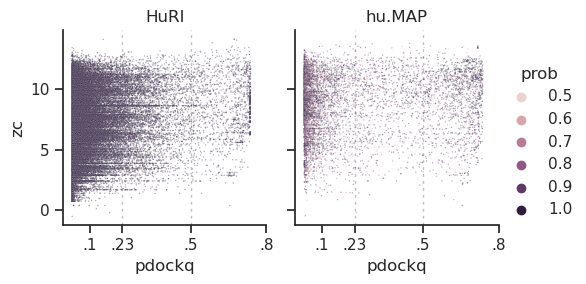

In [368]:
sn = sns.relplot(
    data=mp,
    kind='scatter',
    x='pdockq',
    y='zc',
    hue='prob',
    col='dataset',
    height=3,
    aspect=.9,
    s=1,
    alpha=.4,
)

sn.set(xscale='linear')
sn.set_titles(col_template='{col_name}')
sn.set(xticks=[.1, .23, .5, .8], xticklabels=['.1', '.23', '.5', '.8'])
for ax in sn.axes.flatten():
    for l in [.23, .5]:
        ax.axvline(x=l, dashes=(2, 3), c='.5', lw=1, alpha=.5, zorder=0)

In [369]:
p, q = mp.loc[mp.dataset == 'hu.MAP', ['pdockq', 'prob']].T.values
spearmanr(p, q)

SignificanceResult(statistic=-0.09236635274481426, pvalue=1.758339413849853e-20)

In [98]:
ours = pd.read_csv('scores.tsv', sep='\t', header=0)
ours['zc'] = ours[['za', 'zb']].min(axis=1)
ours['dc'] = ours[['da', 'db']].max(axis=1)
ours.head()

,ida,idb,label,index,lena,lenb,chunk,model,ptm,iptm,...,zb,da,db,M0,M0x,m0xc,m0c,capri,zc,dc
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,1,0,230,460,5,4,0.64,0.43,...,10.537396,0.591304,0.182609,0.000883,0.003954,3,1,acceptable,6.533676,0.591304
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,1,1,230,351,5,2,0.27,0.08,...,8.990527,0.591304,0.307692,0.000869,0.003952,2,1,incorrect,6.533676,0.591304
2,CRC-001576EA78C61C85,CRC-2743716544288776,1,2,230,137,5,4,0.42,0.41,...,10.560456,0.591304,0.357664,0.000916,0.004022,2,1,incorrect,6.533676,0.591304
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,1,3,230,478,5,5,0.26,0.09,...,11.606744,0.591304,0.094142,0.000879,0.003926,3,1,incorrect,6.533676,0.591304
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,1,4,230,723,5,2,0.43,0.11,...,9.997539,0.591304,0.304288,0.001181,0.003942,3,1,incorrect,6.533676,0.591304


## big scatter: matplotlib FTW

In [99]:
ours.columns

Index(['ida', 'idb', 'label', 'index', 'lena', 'lenb', 'chunk', 'model', 'ptm',
       'iptm', 'pdockq', 'ppv', 'za', 'zb', 'da', 'db', 'M0', 'M0x', 'm0xc',
       'm0c', 'capri', 'zc', 'dc'],
      dtype='object')

In [100]:
mp.columns

Index(['ida', 'idb', 'pdockq', 'dataset', 'prob', 'hash_A', 'hash_B', 'za',
       'zb', 'da', 'db', 'zc', 'dc', 'capri'],
      dtype='object')

In [231]:
mpr2k = pd.concat((mp.loc[mp.dataset == 'HuRI'].copy(), r2k))
mpr2k.prob = mpr2k.prob > 0
mpr2k.prob.unique()

array([ True, False])

/tmp/ipykernel_9768/3663185004.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


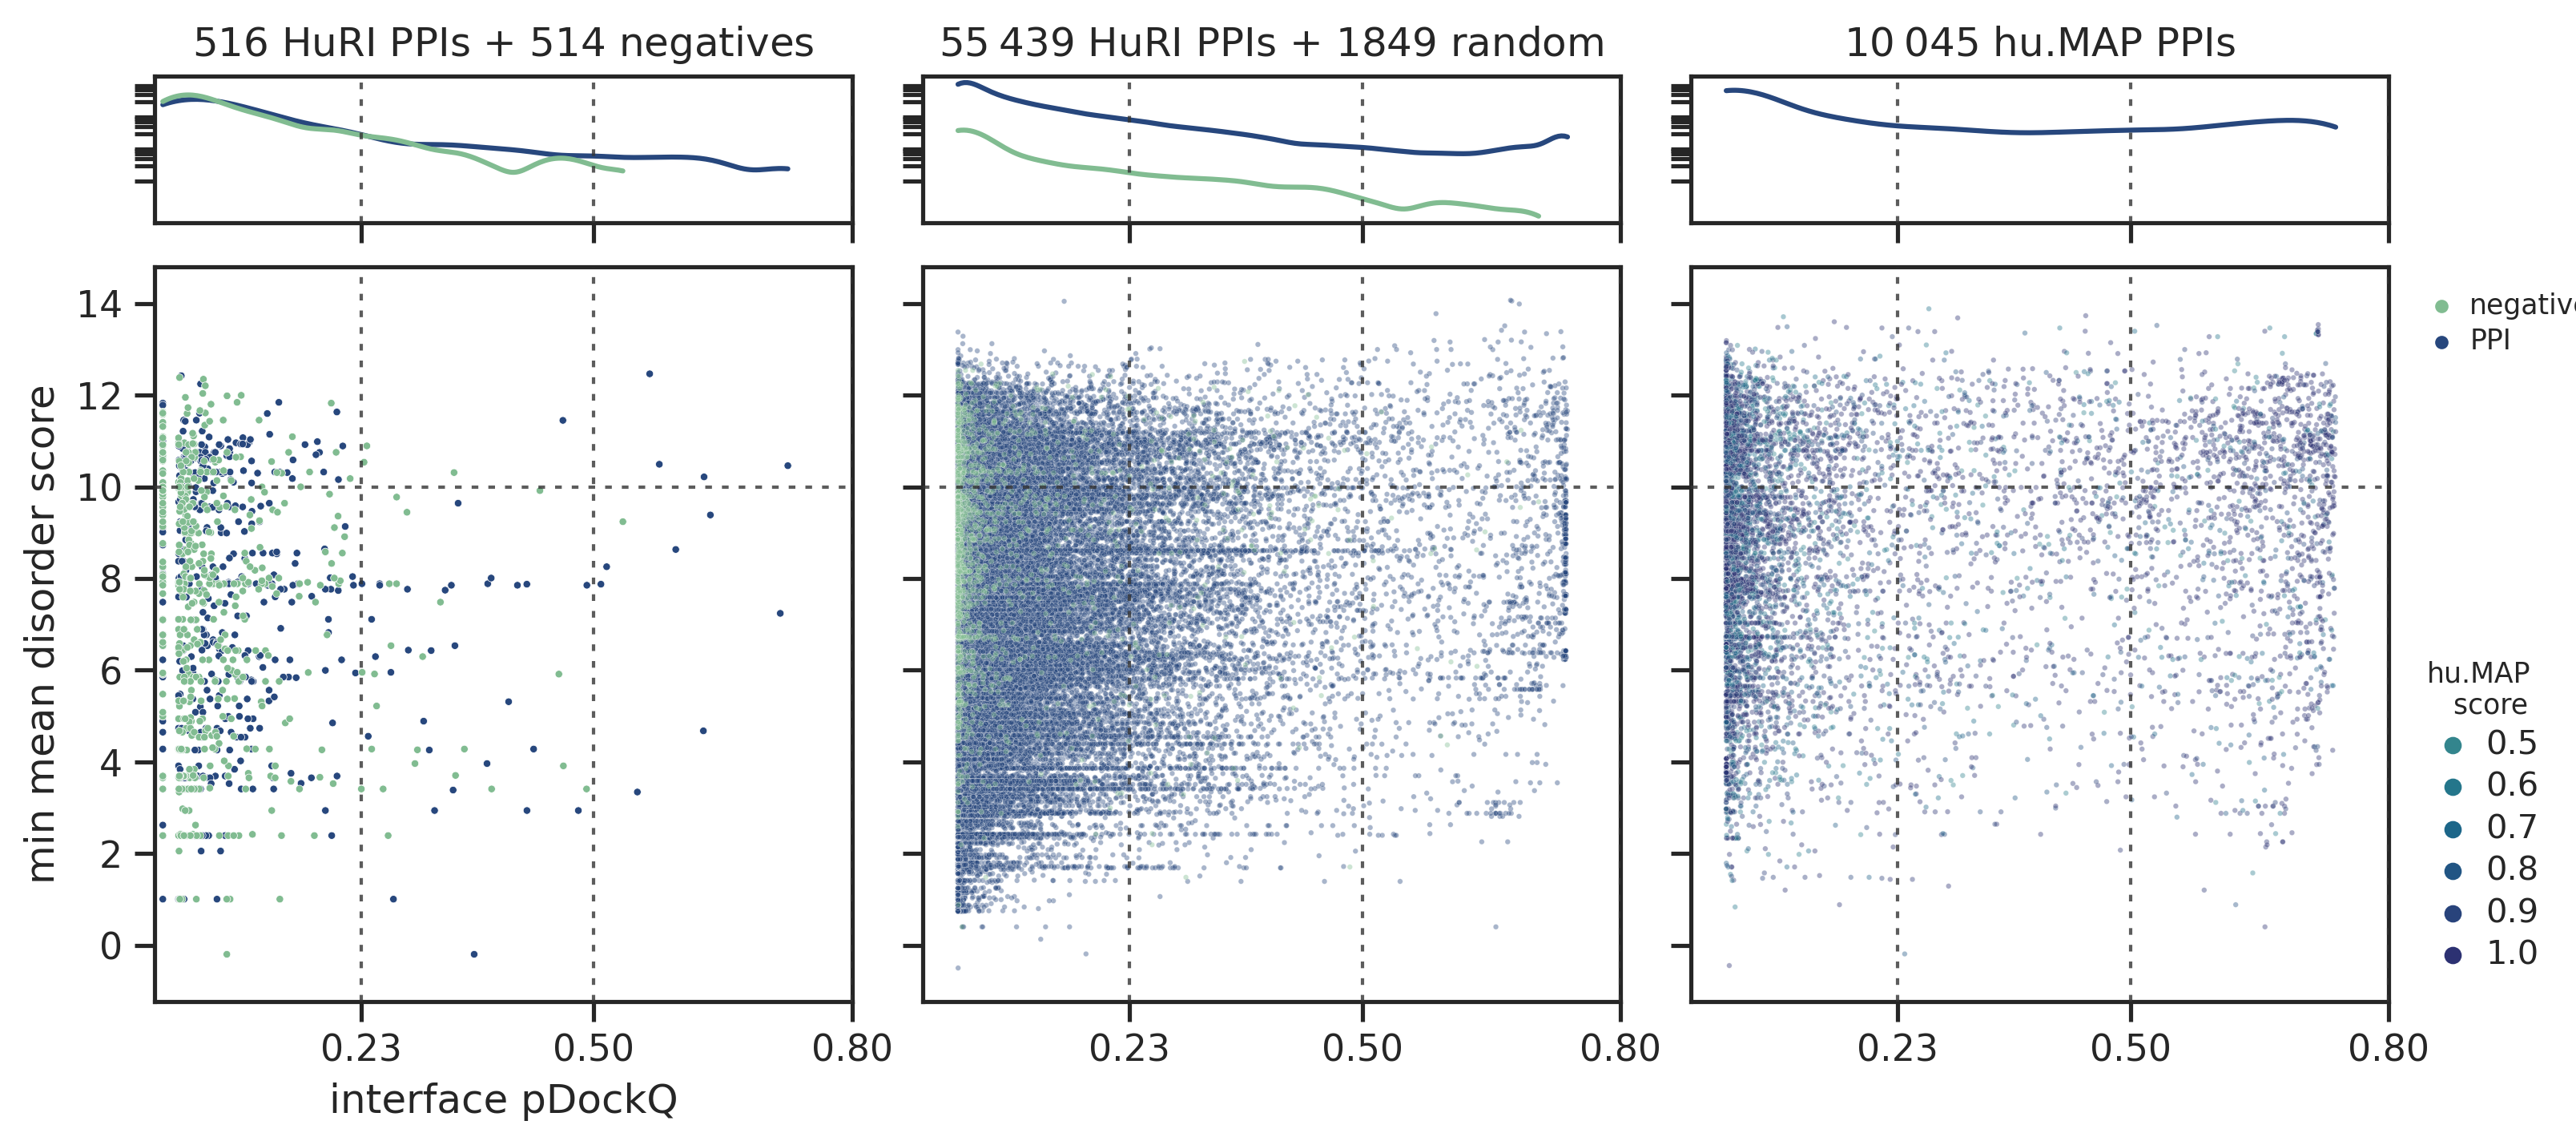

In [342]:
with mpl.rc_context({'figure.dpi': 300}):
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row',
                             gridspec_kw=dict(height_ratios=[1, 5],
                                              wspace=.1, hspace=.1,
                                              ),
                             figsize=(12, 5))

    # pal = sns.cubehelix_palette(7, start=.5, rot=-.75).as_hex()[1::4]
    l, m, r = sns.color_palette('crest', 7)[0::3]
    pal = [l, r]
    sns.kdeplot(data=ours,
                x='pdockq',
                hue='prob', palette=pal,
                # bins=15,
                cut=0, clip=(0, .8),
                # bw_adjust=.5,
                legend=False,
                ax=axes[0, 0],
                )
    sns.kdeplot(data=mpr2k,
                x='pdockq',
                hue='prob', palette=pal,
                # bins=15,
                cut=0, clip=(0, .8),
                # bw_adjust=.5,
                legend=False,
                ax=axes[0, 1],
                )
    sns.kdeplot(data=mp.loc[mp.dataset == 'hu.MAP'],
                x='pdockq',
                # bins=15,
                cut=0, clip=(0, .8),
                color=r,
                # bw_adjust=.5,
                legend=False,
                ax=axes[0, 2],
                )

    axes[0, 0].set(yscale='log', xscale='linear', ylabel=None, xlim=(-.01, None))
    ra = list(range(1, 10, 2))
    ra = [_r / 100 for _r in ra] + [_r / 10 for _r in ra] + ra
    axes[0, 0].set(yticks=ra, yticklabels=[], xticks=[.23, .5, .8])

    s = 5
    al = 1

    sns.scatterplot(data=ours,
                    x='pdockq',
                    y='zc',
                    hue='prob', palette=pal,
                    legend=True,
                    s=s, alpha=al,
                    ax=axes[1, 0],
                    )

    handles, labels = axes[1, 0].get_legend_handles_labels()
    l1 = list(handles), ['negative', 'PPI']
    l1 = axes[1, 2].legend(*l1,
                           handletextpad=0, labelspacing=.3,
                           markerscale=.5, fontsize='x-small',
                           bbox_to_anchor=(1, 1), loc='upper left',
                           frameon=False)
    axes[1, 2].add_artist(l1)
    axes[1, 0].get_legend().remove()

    sns.scatterplot(data=mpr2k,
                    x='pdockq',
                    y='zc',
                    hue='prob', palette=pal,
                    legend=False,
                    s=s / 2, alpha=al * .4,
                    ax=axes[1, 1],
                    rasterized=True,
                    )
    sns.scatterplot(data=mp.loc[mp.dataset == 'hu.MAP'],
                    x='pdockq',
                    y='zc',
                    hue='prob', hue_norm=(0, 1), palette='crest',
                    legend=True,
                    s=s / 2, alpha=al * .4,
                    ax=axes[1, 2],
                    rasterized=True,
                    )
    l1 = axes[1, 2].get_legend_handles_labels()
    l1 = axes[1, 2].legend(*l1,
                           title='hu.MAP\n   score', title_fontsize='x-small',
                           handletextpad=0, labelspacing=.3,
                           markerscale=.7, fontsize='small',
                           bbox_to_anchor=(1, 0), loc='lower left',
                           frameon=False)
    axes[1, 2].add_artist(l1)
    axes[1, 2].get_legend().remove()

    for ax in axes.flatten():
        for l in [.23, .5, .8]:
            ax.axvline(x=l, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
        if ax != axes[1, 0]:
            ax.set(xlabel='')
        else:
            ax.set(ylabel='min mean disorder score', xlabel='interface pDockQ')
    for ax in axes[1, :]:
        ax.axhline(y=10, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
    for ax, t in zip(axes[0, :],
                     ['$516$ HuRI PPIs + $514$ negatives', f'$55\>439$ HuRI PPIs + {len(r2k)} random', '$10\>045$ hu.MAP PPIs']):
        ax.set_title(t)
fig.tight_layout()

In [343]:
fig.savefig('plots/chezod_all.pdf')

In [327]:
ours.prob.value_counts()

1    516
0    514
Name: prob, dtype: int64

In [328]:
mp.dataset.value_counts()

HuRI      55439
hu.MAP    10045
Name: dataset, dtype: int64

In [247]:
ppal = sns.color_palette('flare', 5)
print(ppal.as_hex())

['#e98768', '#de5d5c', '#c14168', '#9a3670', '#722c6e']


In [477]:
ppal = sns.color_palette('deep', 5)
print(ppal.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']


In [276]:
print(sns.color_palette('deep', 2).as_hex()[::-1])

['#dd8452', '#4c72b0']


In [266]:
r2k_ids = get_ids(r2k)
in_huri = r2k_ids & get_ids(mp.loc[mp.dataset=='HuRI'])
in_humap = r2k_ids & get_ids(mp.loc[mp.dataset=='hu.MAP'])
neither = r2k_ids - get_ids(mp)
len(r2k_ids), len(in_huri), len(in_humap), len(neither)

(1533, 732, 1496, 19)

In [208]:
len(r2k)

1849

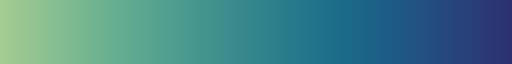

In [297]:
sns.color_palette('crest', as_cmap=True)

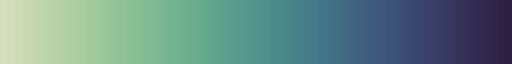

In [291]:
sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

In [316]:
sns.cubehelix_palette(4, start=.5, rot=-.75)

[[0.8423298817793848, 0.8737404427964184, 0.7524954030731037],
 [0.4576142801317438, 0.7057950454122253, 0.5634791991994519],
 [0.25744332683867743, 0.42368146872794976, 0.5191691971789513],
 [0.17250549177124488, 0.11951843162770594, 0.24320155229883056]]